# WGAN (Wasserstein Loss)

100%|██████████| 170M/170M [00:12<00:00, 13.1MB/s]


Epoch [0/50] | C Loss: -69.9333 | G Loss: 45.7988
Epoch [1/50] | C Loss: -96.0345 | G Loss: 48.2760
Epoch [2/50] | C Loss: -96.0426 | G Loss: 48.1577
Epoch [3/50] | C Loss: -96.0817 | G Loss: 48.1509
Epoch [4/50] | C Loss: -96.8925 | G Loss: 48.5154
Epoch [5/50] | C Loss: -96.8246 | G Loss: 48.4672
Epoch [6/50] | C Loss: -96.8922 | G Loss: 48.5115
Epoch [7/50] | C Loss: -95.8897 | G Loss: 48.0278
Epoch [8/50] | C Loss: -93.5423 | G Loss: 46.5926
Epoch [9/50] | C Loss: -94.1049 | G Loss: 47.1645
Epoch [10/50] | C Loss: -97.0128 | G Loss: 48.5299
Epoch [11/50] | C Loss: -97.0349 | G Loss: 48.5361
Epoch [12/50] | C Loss: -94.0196 | G Loss: 47.3192
Epoch [13/50] | C Loss: -96.7324 | G Loss: 48.4184
Epoch [14/50] | C Loss: -96.5497 | G Loss: 48.3000
Epoch [15/50] | C Loss: -93.0168 | G Loss: 46.8296
Epoch [16/50] | C Loss: -95.7696 | G Loss: 48.0908
Epoch [17/50] | C Loss: -95.0237 | G Loss: 48.1030
Epoch [18/50] | C Loss: -96.1335 | G Loss: 48.0539
Epoch [19/50] | C Loss: -96.5853 | G Loss

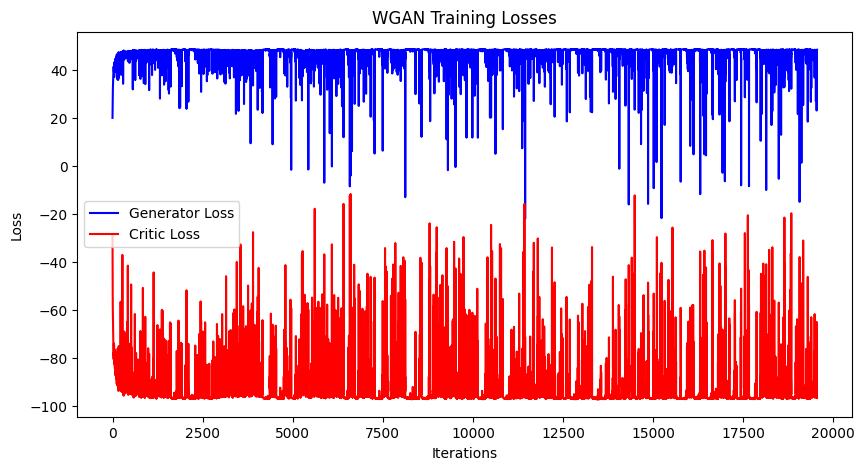

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Hyperparameters
latent_dim = 100
batch_size = 128
epochs = 50
lr = 0.00005
n_critic = 5  # Number of critic iterations per generator iteration
clip_value = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directories
os.makedirs("images_wgan", exist_ok=True)

# Dataset (CIFAR-10)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Critic (WGAN uses critic instead of discriminator)
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
        )

    def forward(self, x):
        return self.main(x).view(-1)

# Initialize models and optimizers
G = Generator().to(device)
C = Critic().to(device)
optimizer_G = optim.RMSprop(G.parameters(), lr=lr)
optimizer_C = optim.RMSprop(C.parameters(), lr=lr)

# Fixed noise for visualization
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

# Training loop
G_losses = []
C_losses = []

for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Train Critic
        for _ in range(n_critic):
            C.zero_grad()

            # Real images
            real_outputs = C(real_imgs)

            # Fake images
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_imgs = G(noise)
            fake_outputs = C(fake_imgs.detach())

            # Wasserstein loss
            c_loss = -(torch.mean(real_outputs) - torch.mean(fake_outputs))
            c_loss.backward()
            optimizer_C.step()

            # Weight clipping
            for p in C.parameters():
                p.data.clamp_(-clip_value, clip_value)

        # Train Generator
        G.zero_grad()
        fake_outputs = C(fake_imgs)
        g_loss = -torch.mean(fake_outputs)
        g_loss.backward()
        optimizer_G.step()

        # Save losses
        G_losses.append(g_loss.item())
        C_losses.append(c_loss.item())

    # Save generated images
    if epoch % 5 == 0:
        with torch.no_grad():
            fake = G(fixed_noise).detach().cpu()
        save_image(fake, f"images_wgan/epoch_{epoch}.png", nrow=8, normalize=True)

    print(f"Epoch [{epoch}/{epochs}] | C Loss: {c_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# Plot losses
plt.figure(figsize=(10, 5))
sns.lineplot(data=G_losses, label="Generator Loss", color="blue")
sns.lineplot(data=C_losses, label="Critic Loss", color="red")
plt.title("WGAN Training Losses")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.savefig("wgan_loss.png")
plt.show()